In [ ]:
#-------------------- ASSIGNMENT 3: HOUSE PRICES --------------------
#                  COMP3122 | KAILIE FIELD | 100627702
#                           15 November 2024
#--------------------------------------------------------------------

In [12]:
#---- IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

In [13]:
#---- LOADING DATASETS
house_train = pd.read_csv("train.csv")
house_test = pd.read_csv("test.csv")

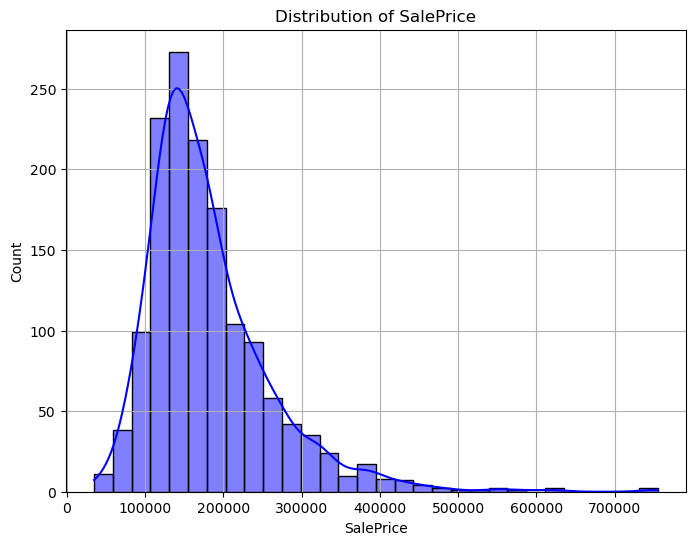

In [14]:
#---- STEP 1: VISUALIZING TARGET VARIABLE
plt.figure(figsize=(8,6))
sns.histplot(house_train['SalePrice'], kde=True, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.grid(True)
plt.show()

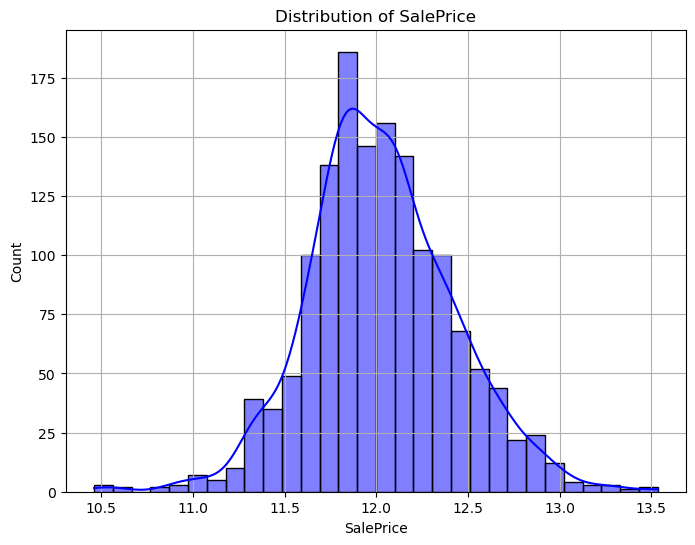

In [15]:
#---- APPLYING LOG TRANSFORMATIONS TO PREVENT SKEWNESS
house_train['SalePrice'] = np.log(house_train['SalePrice'])
#---- visualizing the transformation
plt.figure(figsize=(8,6))
sns.histplot(house_train['SalePrice'], kde=True, bins=30, color='blue', edgecolor='black')
plt.title('Distribution of SalePrice')
plt.xlabel('SalePrice')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [16]:
#---- STEP 2: HANDLE MISSING VALUES
numeric_columns_train = house_train.select_dtypes(include=['number']).columns
numeric_columns_test = [col for col in numeric_columns_train if col in house_test.columns]
#---- fill missing values for numerical columns with the mean
house_train[numeric_columns_train] = house_train[numeric_columns_train].fillna(house_train[numeric_columns_train].mean())
house_test[numeric_columns_test] = house_test[numeric_columns_test].fillna(house_test[numeric_columns_test].mean())

#---- VISUALIZE
print(house_train[numeric_columns_train].describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    22.024023    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    60.000000    7553.500000     5.000000   
50%     730.500000    50.000000    70.049958    9478.500000     6.000000   
75%    1095.250000    70.000000    79.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1460.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   180.569112   456.098091  ..